<a href="https://colab.research.google.com/github/johan-lindell/VSL-egocentric/blob/main/notebooks/ego4d_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ego4D dataset analysis

## Setup

In [1]:
import os
from google.colab import userdata

#Add secrets to google colab
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('aws_access_key')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('aws_secret_key')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#set directory names
BASE_DIR = '/content/drive/MyDrive/vsl-egocentric'
EGO4D_DATA = BASE_DIR + '/ego4d_data'

Mounted at /content/drive


In [3]:
#If directory does not exist download data
#Please delete directoy from persistant storage to redonwload data
if not os.path.exists(EGO4D_DATA):
  print("data not in persistant storage -> downloading ego4D")
  !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
  !unzip -o awscliv2.zip >/dev/null
  !sudo ./aws/install >/dev/null 2>&1
  !aws configure set aws_access_key_id "$AWS_ACCESS_KEY_ID" && aws configure set aws_secret_access_key "$AWS_SECRET_ACCESS_KEY"
  !rm "awscliv2.zip"
  !pip install ego4d
  !ego4d --version v1 --output_directory=$EGO4D_DATA --datasets annotations omnivore_video_swinl_fp16 --benchmarks nlq -y


## Stats for Data

In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
%matplotlib inline

In [6]:
ann_data = json.load(open(EGO4D_DATA + "/v1/annotations/nlq_train.json"))

In [7]:
# please see https://ego4d-data.org/docs/data/annotations-schemas/

anns = []
for vid in ann_data["videos"]:
    for clip in vid["clips"]:
        for ann in clip["annotations"]:
            for query in ann["language_queries"]:
                anns.append({
                    "query_start_time_sec": clip["video_start_sec"],
                    "query_end_time_sec": clip["video_end_sec"],
                    "query_response_start_time_sec": query["video_start_sec"],
                    "query_response_end_time_sec": query["video_end_sec"],
                    "query_template": query.get("template", None),
                    "query": query.get("query", None),
                })

In [8]:
num_queries = len(anns)
relative_query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"]) / (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])
query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"])
    for a in anns
])
clip_sizes = np.array([
    (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])

## Query / Response Durations

Here we can see that there are some queries with 0s. When training it is reccomended to remove them from the set. For VSLNet you can provide `--remove_empty_queries_from train` to `main.py` (e.g. if you are modifying this codebase).

In [9]:
query_sizes.max(), query_sizes.min(), query_sizes.std()

(480.0, 0.0, 22.82781402544118)

In [10]:
# less than or equal to 4 frames => 9% of training data
(query_sizes <= 4/30).sum() / len(relative_query_sizes)

0.09012039660056657

## Distribution of Queries (relative)

In [11]:
plt.rcParams["figure.figsize"] = (16, 9)

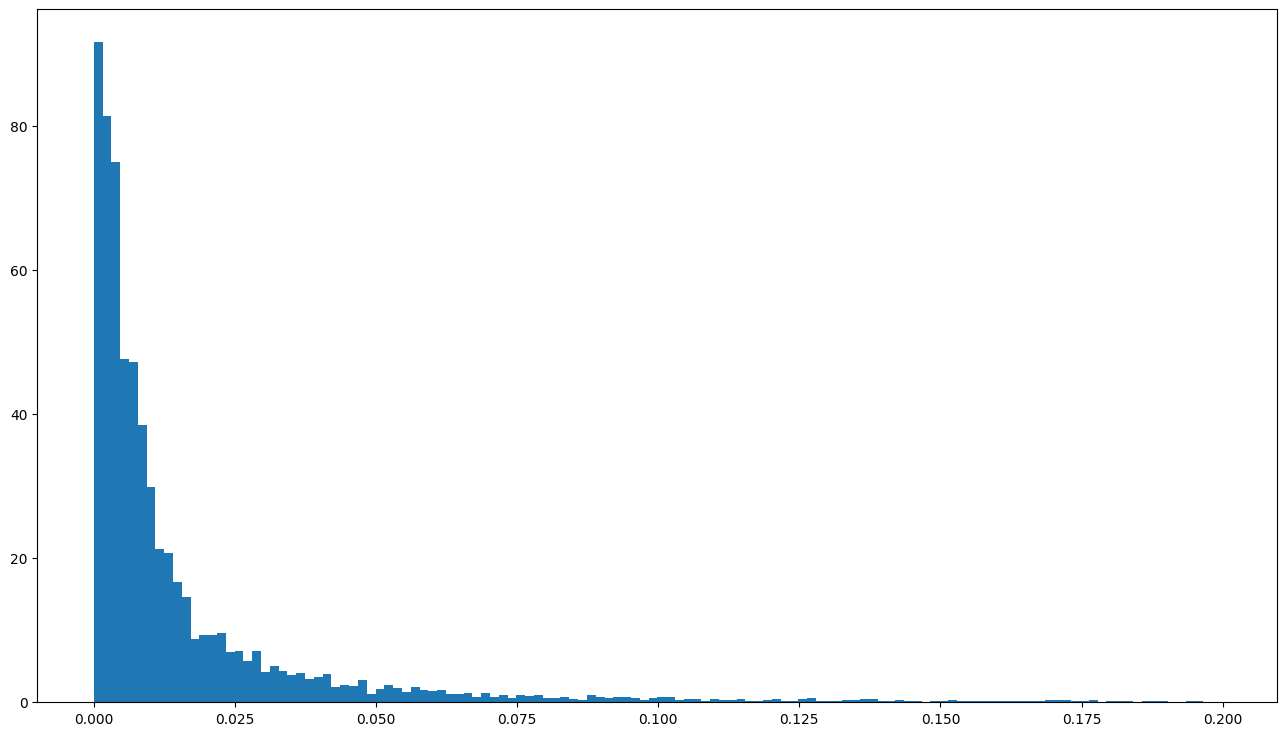

In [12]:
plt.hist(relative_query_sizes[relative_query_sizes < 0.2], density=True, bins=128)
plt.show()

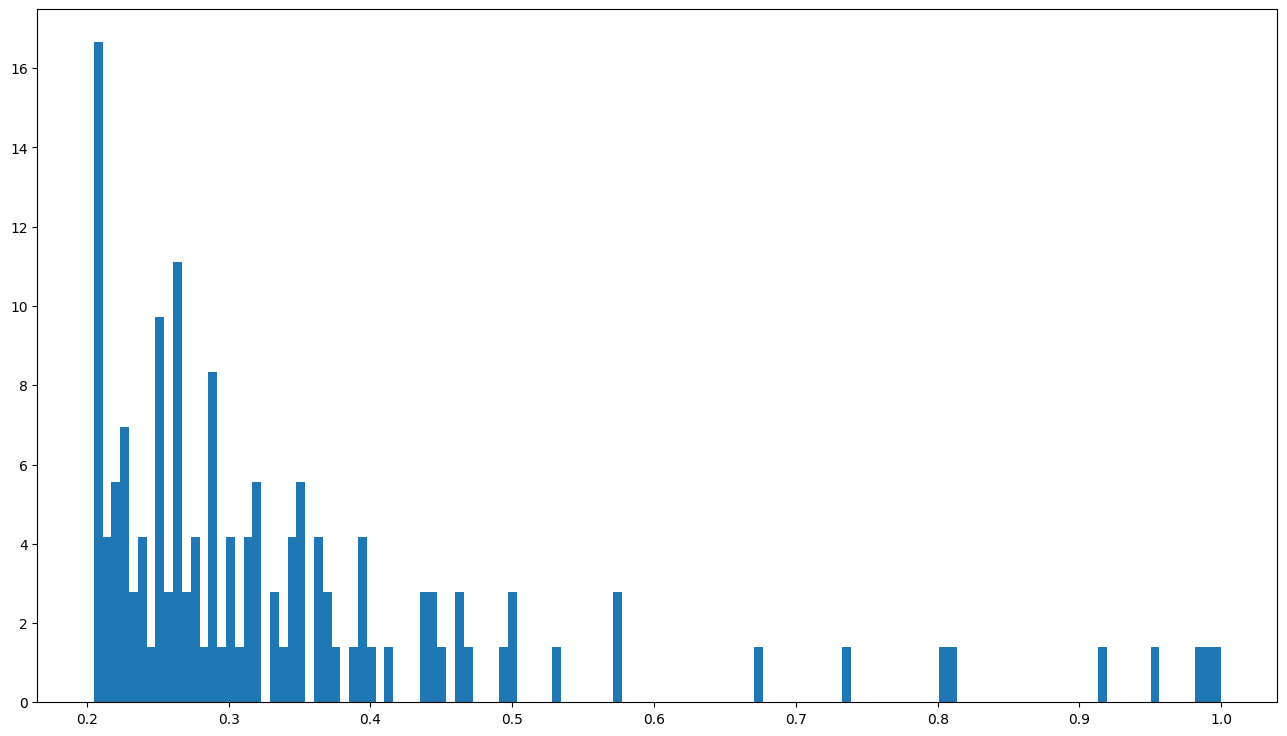

In [13]:
plt.hist(relative_query_sizes[relative_query_sizes > 0.2], density=True, bins=128)
plt.show()

## Clip Sizes

Clips are 522s on average, with most clips being 480s.

In [14]:
clip_sizes.mean(), clip_sizes.max(), clip_sizes.min(), clip_sizes.std(), np.median(clip_sizes)

(522.6759852928087,
 1200.0666422526042,
 207.16666666666674,
 197.6377591205408,
 480.0)

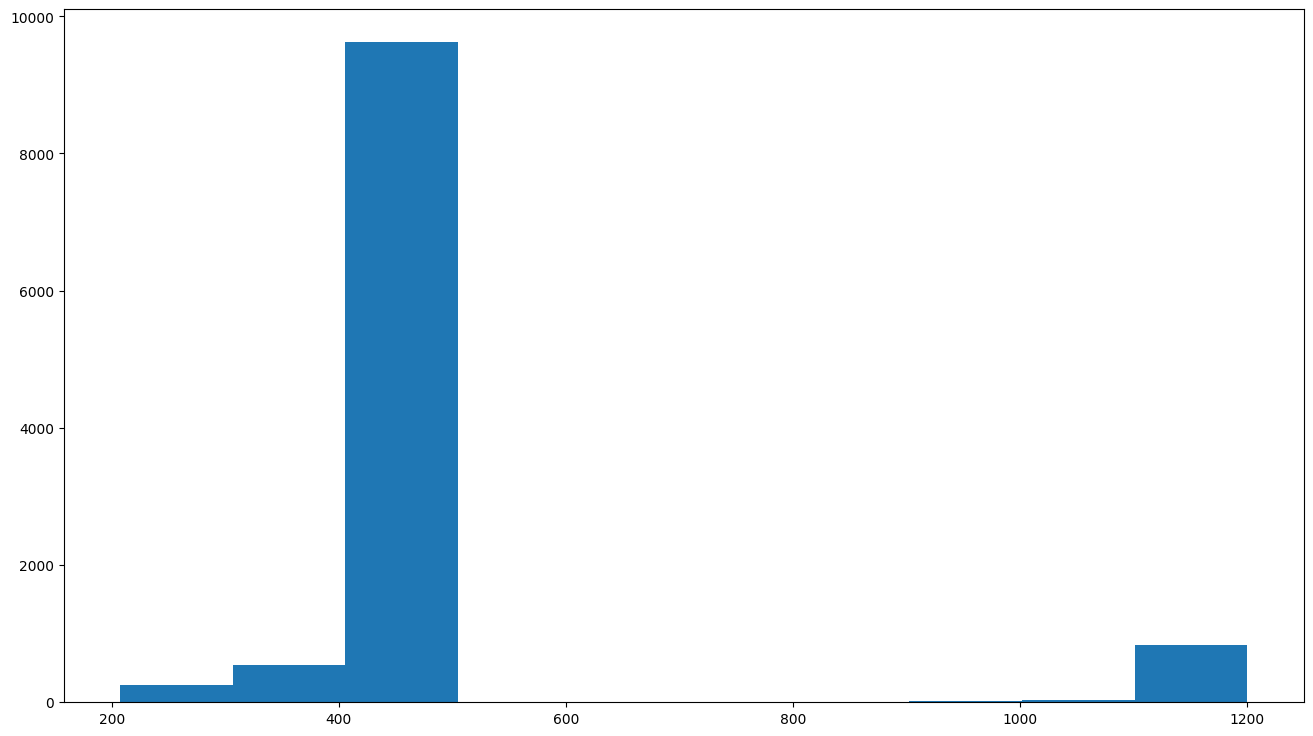

In [15]:
plt.hist(clip_sizes)
plt.show()

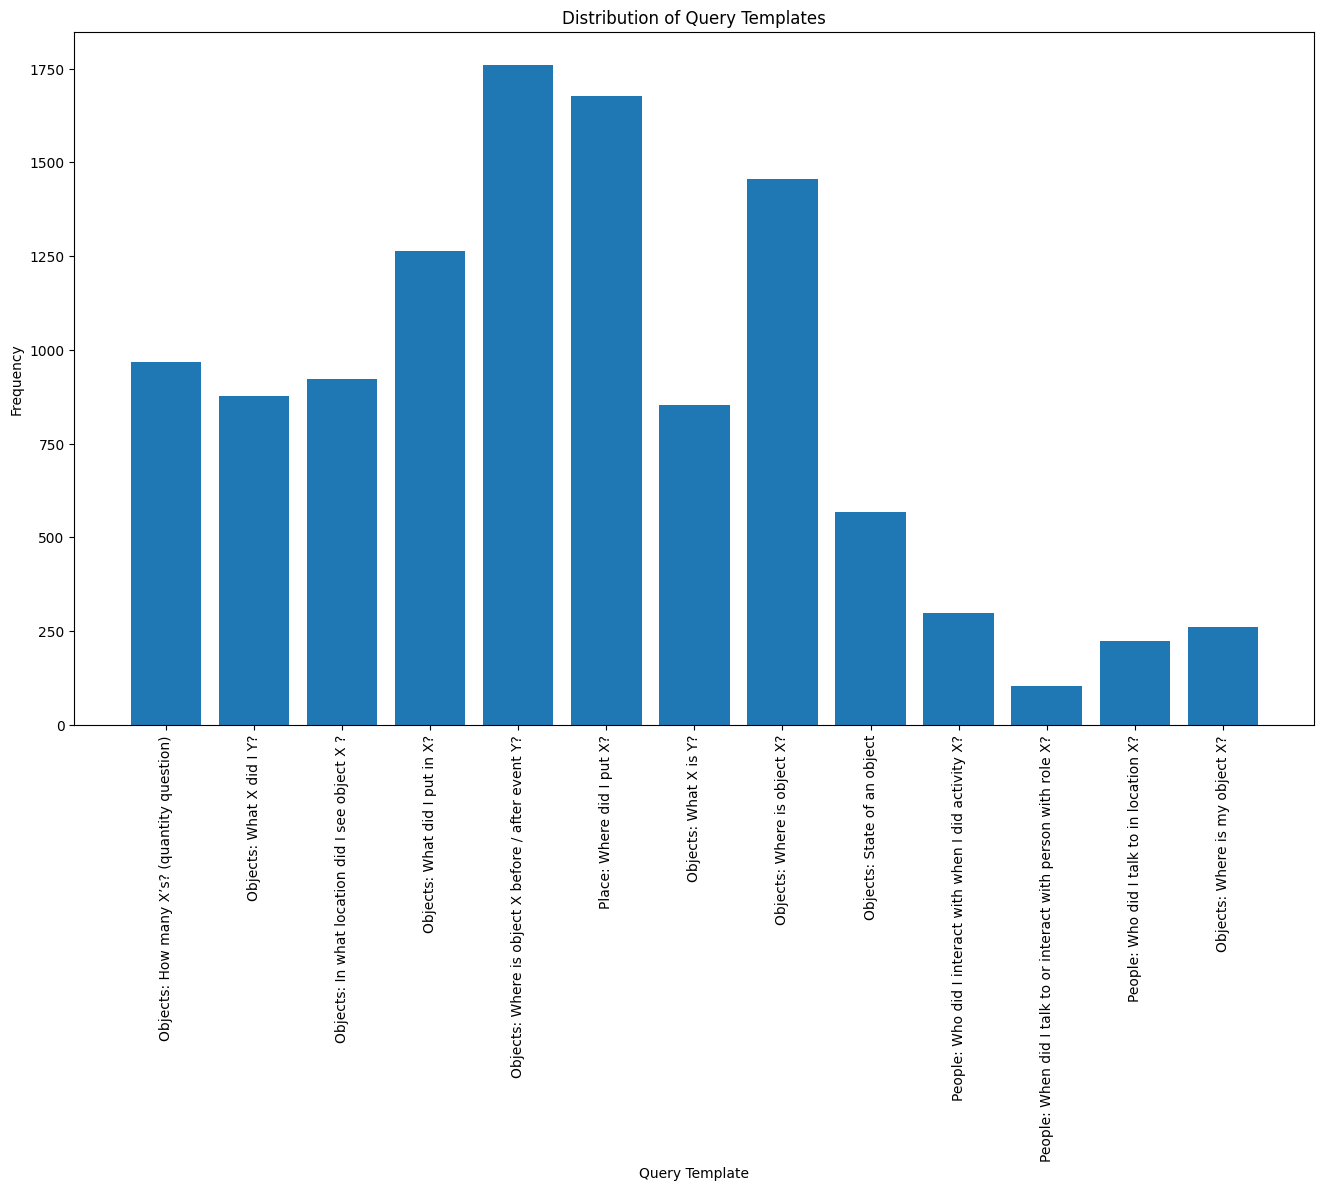

In [16]:
# Count the occurrences of each template
template_counts = Counter(a['query_template'] for a in anns if a['query_template'] is not None)

# Plot the distribution of query templates
plt.figure(figsize=(16, 9))
plt.bar(template_counts.keys(), template_counts.values())
plt.xlabel('Query Template')
plt.ylabel('Frequency')
plt.title('Distribution of Query Templates')
plt.xticks(rotation=90)
plt.show()


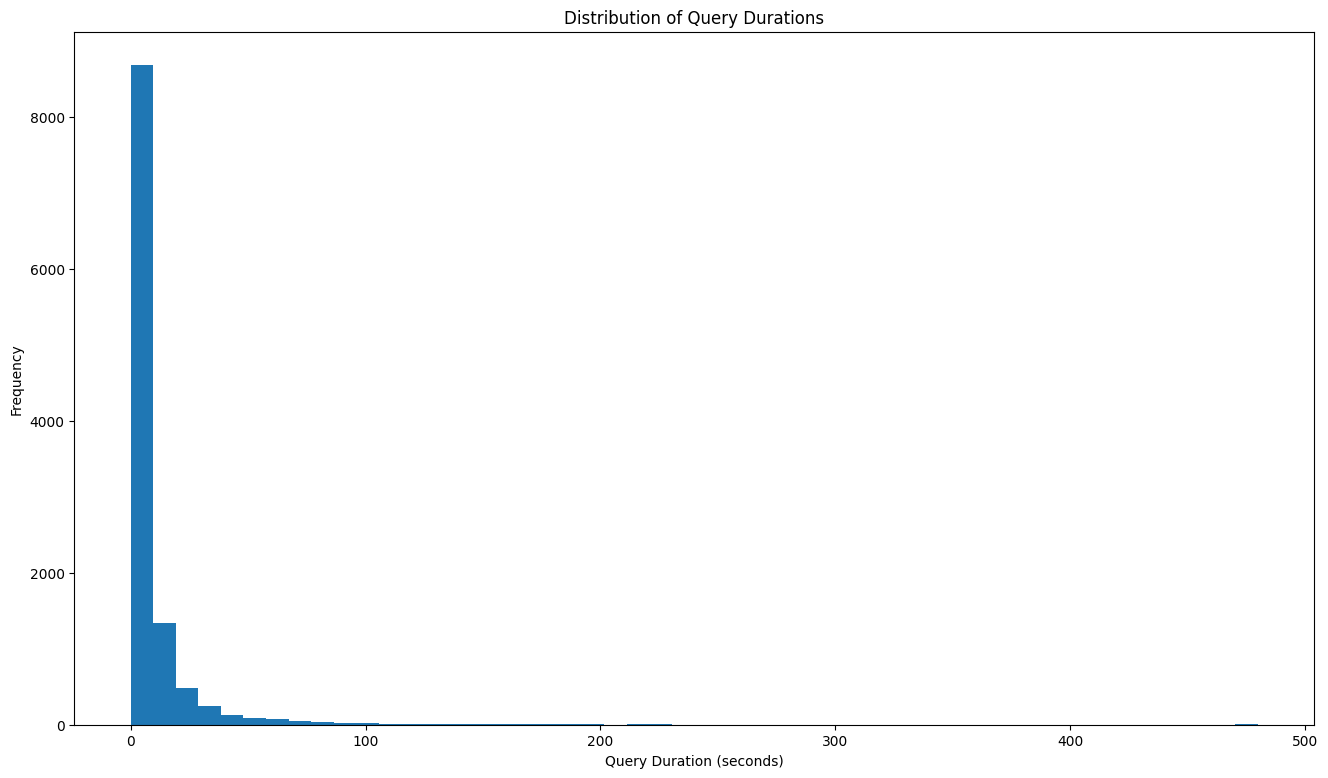

In [20]:
# Plot the distribution of query durations
plt.figure(figsize=(16, 9))
plt.hist(query_sizes, bins=50)
plt.xlabel('Query Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Query Durations')
plt.show()

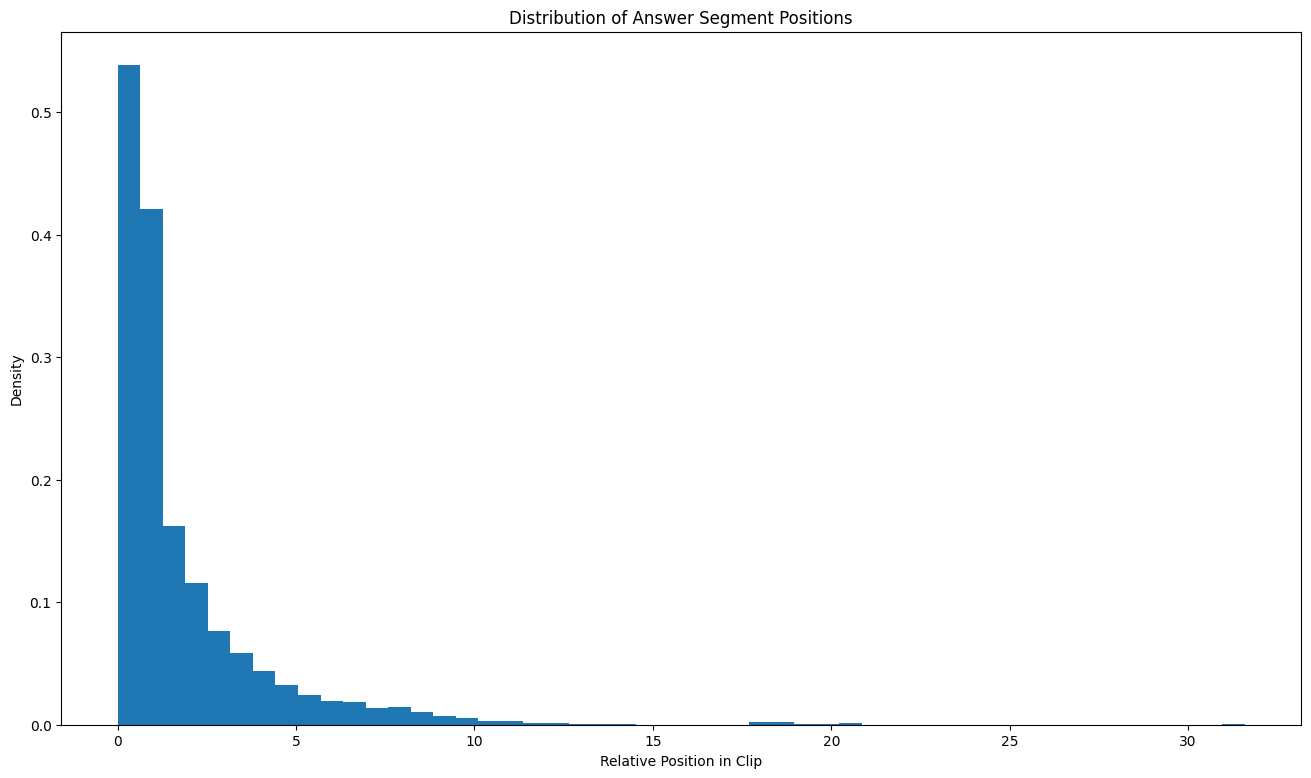

In [21]:
# Calculate the position of answer segments within the clips
answer_segment_positions = np.array([
    (a["query_response_start_time_sec"] + a["query_response_end_time_sec"]) / 2 / (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])

# Plot the distribution of answer segment positions
plt.figure(figsize=(16, 9))
plt.hist(answer_segment_positions, bins=50, density=True)
plt.xlabel('Relative Position in Clip')
plt.ylabel('Density')
plt.title('Distribution of Answer Segment Positions')
plt.show()


In [22]:
# Create a DataFrame for statistical summary
df = pd.DataFrame({
    'query_size': query_sizes,
    'clip_size': clip_sizes,
    'relative_query_size': relative_query_sizes
})

# Display summary statistics
summary_stats = df.describe()
print(summary_stats)


         query_size     clip_size  relative_query_size
count  11296.000000  11296.000000         11296.000000
mean       9.670475    522.675985             0.019533
std       22.828825    197.646508             0.046186
min        0.000000    207.166667             0.000000
25%        1.465605    480.000000             0.002867
50%        3.454305    480.000000             0.006958
75%        8.739587    480.036674             0.017365
max      480.000000   1200.066642             0.999924
